In [1]:
# Imports math library
import numpy as np
# Imports plotting library
import matplotlib.pyplot as plt
# Import math Library
import math

In [2]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

# Define a shallow neural network
def shallow_nn(x, beta_0, omega_0, beta_1, omega_1):
    # Make sure that input data is (1 x n_data) array
    n_data = x.size
    x = np.reshape(x,(1,n_data))

    # This runs the network for ALL of the inputs, x at once so we can draw graph
    h1 = ReLU(np.matmul(beta_0,np.ones((1,n_data))) + np.matmul(omega_0,x))
    model_out = np.matmul(beta_1,np.ones((1,n_data))) + np.matmul(omega_1,h1)
    return model_out

In [3]:
# Get parameters for model -- we can call this function to easily reset them
def get_parameters():
  # And we'll create a network that approximately fits it
  beta_0 = np.zeros((3,1));  # formerly theta_x0
  omega_0 = np.zeros((3,1)); # formerly theta_x1
  beta_1 = np.zeros((1,1));  # formerly phi_0
  omega_1 = np.zeros((1,3)); # formerly phi_x

  beta_0[0,0] = 0.3; beta_0[1,0] = -1.0; beta_0[2,0] = -0.5
  omega_0[0,0] = -1.0; omega_0[1,0] = 1.8; omega_0[2,0] = 0.65
  beta_1[0,0] = 2.6;
  omega_1[0,0] = -24.0; omega_1[0,1] = -8.0; omega_1[0,2] = 50.0

  return beta_0, omega_0, beta_1, omega_1

In [5]:
# Utility function for plotting data
def plot_binary_classification(x_model, out_model, lambda_model, x_data = None, y_data = None, title= None):
  # Make sure model data are 1D arrays
  x_model = np.squeeze(x_model)
  out_model = np.squeeze(out_model)
  lambda_model = np.squeeze(lambda_model)

  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(7.0, 3.5)
  fig.tight_layout(pad=3.0)
  ax[0].plot(x_model,out_model)
  ax[0].set_xlabel(r'Input, '); ax[0].set_ylabel(r'Model output')
  ax[0].set_xlim([0,1]);ax[0].set_ylim([-4,4])
  if title is not None:
    ax[0].set_title(title)
  ax[1].plot(x_model,lambda_model)
  ax[1].set_xlabel(r'Input, '); ax[1].set_ylabel(r'or Pr(y=1|x)')
  ax[1].set_xlim([0,1]);ax[1].set_ylim([-0.05,1.05])
  if title is not None:
    ax[1].set_title(title)
  if x_data is not None:
    ax[1].plot(x_data, y_data, 'ko')
  plt.show()

In [6]:
# Sigmoid function that maps [-infty,infty] to [0,1]
def sigmoid(model_out):
  # Equation 5.18: sig(z) = 1 / (1 + exp(-z))
  # This maps the raw model output (logits) to a probability between 0 and 1
  sig_model_out = 1 / (1 + np.exp(-model_out))

  return sig_model_out

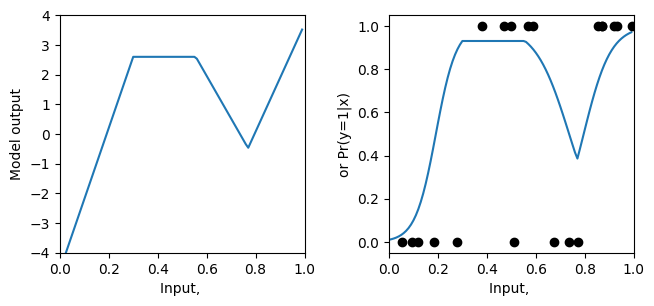

In [7]:
# Let's create some 1D training data
x_train = np.array([0.09291784,0.46809093,0.93089486,0.67612654,0.73441752,0.86847339,\
                   0.49873225,0.51083168,0.18343972,0.99380898,0.27840809,0.38028817,\
                   0.12055708,0.56715537,0.92005746,0.77072270,0.85278176,0.05315950,\
                   0.87168699,0.58858043])
y_train = np.array([0,1,1,0,0,1,\
                    1,0,0,1,0,1,\
                    0,1,1,0,1,0, \
                    1,1])

# Get parameters for the model
beta_0, omega_0, beta_1, omega_1 = get_parameters()

# Define a range of input values
x_model = np.arange(0,1,0.01)
# Run the model to get values to plot and plot it.
model_out= shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
lambda_model = sigmoid(model_out)
plot_binary_classification(x_model, model_out, lambda_model, x_train, y_train)

In [8]:
# Return probability under Bernoulli distribution for observed class y
def bernoulli_distribution(y, lambda_param):
    # Equation 5.17: P(y) = lambda^y * (1 - lambda)^(1 - y)
    # y must be 0 or 1. lambda_param is the probability of class 1.
    
    # Use np.power for element-wise exponentiation
    prob = np.power(lambda_param, y) * np.power((1 - lambda_param), (1 - y))

    return prob

In [9]:
# Let's double check we get the right answer before proceeding
print("Correct answer = %3.3f, Your answer = %3.3f"%(0.8,bernoulli_distribution(0,0.2)))
print("Correct answer = %3.3f, Your answer = %3.3f"%(0.2,bernoulli_distribution(1,0.2)))

Correct answer = 0.800, Your answer = 0.800
Correct answer = 0.200, Your answer = 0.200


In [10]:
# Return the likelihood of all of the data under the model
def compute_likelihood(y_train, lambda_param):
  # 1. Calculate the Bernoulli probability for each individual observation
  # This uses the lambda (probability of class 1) predicted by your sigmoid
  probs = bernoulli_distribution(y_train, lambda_param)
  
  # 2. Compute the likelihood: the product of all these individual probabilities
  # Equation 5.3: L = Π P(y_i | lambda_i)
  likelihood = np.prod(probs)

  return likelihood

In [11]:
# Let's test this
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the Bernoulli parameter lambda
model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
lambda_train = sigmoid(model_out)
# Compute the likelihood
likelihood = compute_likelihood(y_train, lambda_train)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(0.000070237,likelihood))

Correct answer = 0.000070237, Your answer = 0.000070237


In [12]:
# Return the negative log likelihood of the data under the model
def compute_negative_log_likelihood(y_train, lambda_param):
  # 1. Calculate the probability for each data point using the Bernoulli distribution
  probs = bernoulli_distribution(y_train, lambda_param)
  
  # 2. Compute the Negative Log Likelihood: -Σ log(P(y_i | lambda_i))
  # This prevents numerical underflow that occurs with np.prod()
  nll = -np.sum(np.log(probs))

  return nll

In [13]:
# Let's test this
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the mean of the Gaussian
model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
# Pass through the sigmoid function
lambda_train = sigmoid(model_out)
# Compute the log likelihood
nll = compute_negative_log_likelihood(y_train, lambda_train)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(9.563639387,nll))

Correct answer = 9.563639387, Your answer = 9.563639387


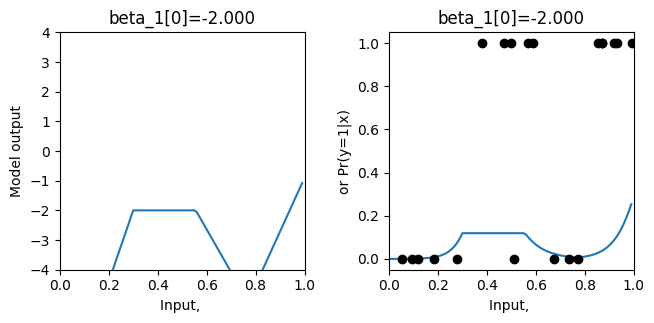

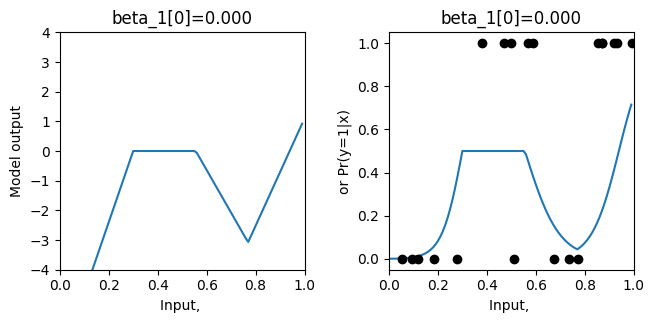

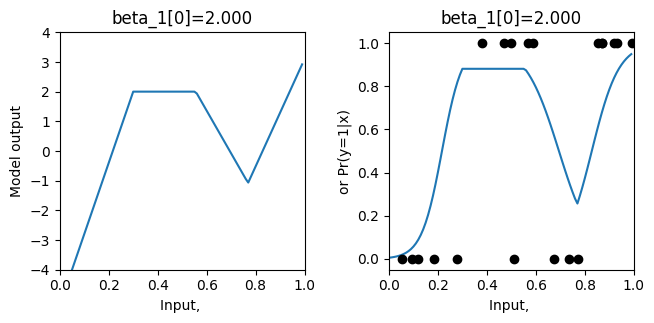

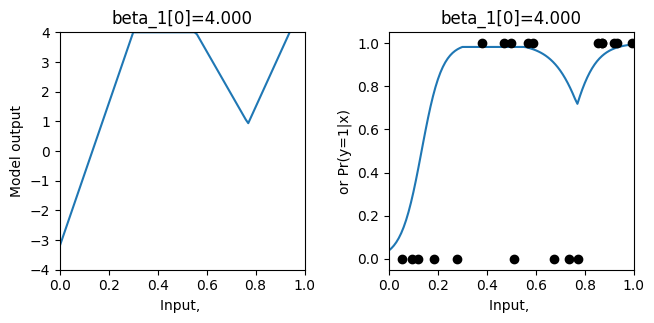

In [14]:
# Define a range of values for the parameter
beta_1_vals = np.arange(-2,6.0,0.1)
# Create some arrays to store the likelihoods, negative log likelihoods
likelihoods = np.zeros_like(beta_1_vals)
nlls = np.zeros_like(beta_1_vals)

# Initialise the parameters
beta_0, omega_0, beta_1, omega_1 = get_parameters()
for count in range(len(beta_1_vals)):
  # Set the value for the parameter
  beta_1[0,0] = beta_1_vals[count]
  # Run the network with new parameters
  model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
  lambda_train = sigmoid(model_out)
  # Compute and store the two values
  likelihoods[count] = compute_likelihood(y_train,lambda_train)
  nlls[count] = compute_negative_log_likelihood(y_train, lambda_train)
  # Draw the model for every 20th parameter setting
  if count % 20 == 0:
    # Run the model to get values to plot and plot it.
    model_out = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
    lambda_model = sigmoid(model_out)
    plot_binary_classification(x_model, model_out, lambda_model, x_train, y_train, title="beta_1[0]=%3.3f"%(beta_1[0,0]))

     

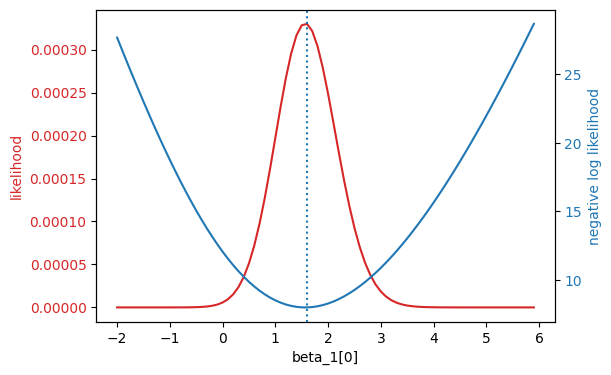

In [15]:
# Now let's plot the likelihood and negative log likelihood as a function of the value of the offset beta1
fig, ax = plt.subplots()
fig.tight_layout(pad=5.0)
likelihood_color = 'tab:red'
nll_color = 'tab:blue'


ax.set_xlabel('beta_1[0]')
ax.set_ylabel('likelihood', color = likelihood_color)
ax.plot(beta_1_vals, likelihoods, color = likelihood_color)
ax.tick_params(axis='y', labelcolor=likelihood_color)

ax1 = ax.twinx()
ax1.plot(beta_1_vals, nlls, color = nll_color)
ax1.set_ylabel('negative log likelihood', color = nll_color)
ax1.tick_params(axis='y', labelcolor = nll_color)

plt.axvline(x = beta_1_vals[np.argmax(likelihoods)], linestyle='dotted')

plt.show()

Maximum likelihood = 0.000330, at beta_1=1.600
Minimum negative log likelihood = 8.016513, at beta_1=1.600


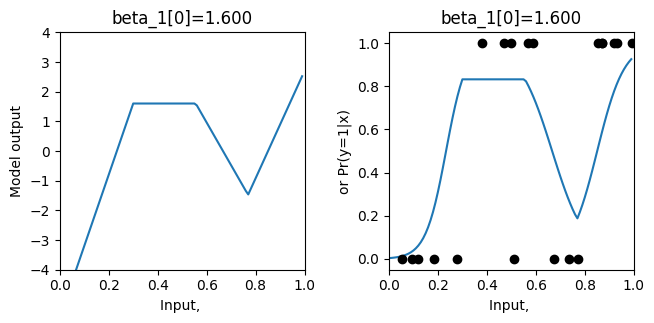

In [16]:
# Hopefully, you can see that the maximum of the likelihood fn is at the same position as the minimum negative log likelihood
# Let's check that:
print("Maximum likelihood = %f, at beta_1=%3.3f"%( (likelihoods[np.argmax(likelihoods)],beta_1_vals[np.argmax(likelihoods)])))
print("Minimum negative log likelihood = %f, at beta_1=%3.3f"%( (nlls[np.argmin(nlls)],beta_1_vals[np.argmin(nlls)])))

# Plot the best model
beta_1[0,0] = beta_1_vals[np.argmin(nlls)]
model_out = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
lambda_model = sigmoid(model_out)
plot_binary_classification(x_model, model_out, lambda_model, x_train, y_train, title="beta_1[0]=%3.3f"%(beta_1[0,0]))

     